In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

# Extracting SST, ONI and Anomaly

In [3]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

In [4]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [5]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [6]:
clm = climatology(nino34)

In [7]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [8]:
anm = SST_anomaly(nino34, clm)
oni = ONI(anm)
time = np.arange(anm.shape[0])

# Converting Time Series to Train/Validation/Test Datasets and Labels

We first decide which time series to use for training (input_signal) and which time series to predict (output_signal):

In [9]:
input_signal = np.array(anm).copy()
output_signal = np.array(oni).copy()

We then normalize the input signal for more reliable performance:

In [10]:
mean = np.mean(input_signal)
std = np.std(input_signal)

input_signal = (input_signal - mean) / std

# Variant 1

We now decide how far into the future we aim to predict (T months into the future), how much history we use to do so (H months of past values information Hmax into the past), and number of extra features (means of previous months).

In [22]:
T = 12
H = 3  
Hmax = 48
features = H + 7 + 6 + 1 # 3 months of values / 7 x 3-month averages / 6 x 4-month months / current month

Now we can create: (1) the feature matrix, i.e. the data to be used to predict the future time series value, and (2) the desired label vector.

In [24]:
np.random.seed(0)
size = input_signal.shape[0] - Hmax - T 
        
data = np.ndarray((size, features))
for i in range(size):
    data[i, 0:H] = input_signal[(i + Hmax - H):(i + Hmax)] # past H exact values
    
    for j in range(7): # 7 x 3-month average
        data[i, H + j] = np.mean(input_signal[(i + Hmax - H - 3 * (j + 1)):(i + Hmax - H - 3 * j)])
    
    for j in range(6): # 6 x 4-month months
        data[i, H + 7 + j] = np.mean(input_signal[(i + Hmax - H - 3 * 7 - 4 * (j + 1)):(i + Hmax - H - 3 * 7 - 4 * j)])
        
    data[i, H + 7 + 6] = ((i + Hmax) % 12 - np.mean(range(12))) / np.std(range(12)) # current month
    

labels = np.ndarray((size, T), dtype = np.float64)
time2D = np.zeros((size, T))

for t in range(T):
    for i in range(size):
        labels[i,t] = output_signal[i + Hmax + t]
        time2D[i, t] = time[i + Hmax + t]

We will use the first 80% of the time series as training data, the following 10% as validation and the last 10% for testing:

In [27]:
split = size // 10      

train = np.array(data[0: 8 * split])
train_labels = np.array(labels[0: 8 * split])

val = np.array(data[8 * split: 9 * split])
val_labels = np.array(labels[8 * split: 9 * split])
val_time2D = np.array(time2D[8 * split: 9 * split])

test = np.array(data[9 * split: size])
test_labels = np.array(labels[9 * split: size])

(Optional) Shuffle Training Data

In [28]:
shuffle = np.random.permutation(8 * split)
train = train[shuffle]
train_labels = train_labels[shuffle]

# Learning Optimal Weights for each t = 1, T separately:

In [42]:
(N1, N2, N3, d) = (128, 256, 256, 0.2)
epochs = 60

individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

In [43]:
val_pred_mse = np.zeros(T)
val_pred_corr = np.zeros(T)
individual_val_pred = {}

In [44]:
for t in range(T):
    
    individual_model.reset_states()

    individual_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

    individual_model.fit(train, train_labels[:, t], epochs = epochs, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    
    val_pred_mse[t] = mean_squared_error(val_labels[:, t].flatten(), individual_val_pred[t])
    val_pred_corr[t] = correlation(val_labels[:, t].flatten(), individual_val_pred[t])

# Learning Optimal Weights for all t simulatously:

In [45]:
cumulative_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

In [46]:
cumulative_model.reset_states()

cumulative_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

cumulative_model.fit(train, train_labels, epochs = epochs, verbose = 0)

In [47]:
cumulative_val_pred = cumulative_model.predict(val)

In [48]:
mult_val_pred_mse = np.zeros(T)
mult_val_pred_corr = np.zeros(T)

mult_val_pred_mse = ((val_labels - cumulative_val_pred)**2).mean(axis = 0)
mult_val_pred_corr = correlation(val_labels, cumulative_val_pred)

# Plotting Results

INDIVIDUAL vs. CUMULATIVE

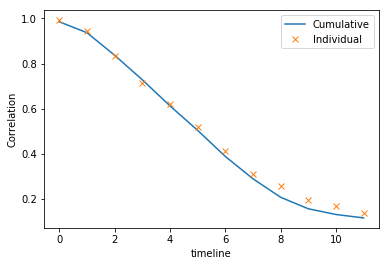

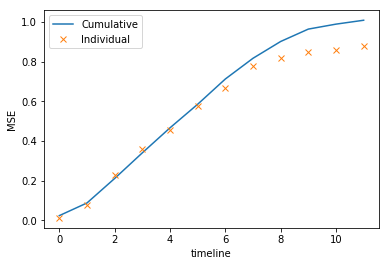

In [49]:
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, 'x', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();

plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, 'x', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

In [50]:
monthly_corr = np.zeros((12, T))
for m in range(12):
    monthly_corr[m] = correlation(val_labels[m::12], cumulative_val_pred[m::12])

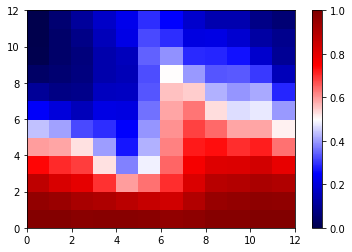

In [51]:
plt.pcolormesh(monthly_corr.T, cmap = plt.cm.seismic);
plt.clim(0, 1)
plt.colorbar();

In [52]:
monthly_rmse = np.zeros((12, T))
for m in range(12):
    monthly_rmse[m] = ((val_labels[m::12] - cumulative_val_pred[m::12])**2).mean(axis = 0)

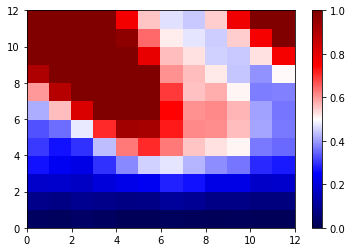

In [53]:
plt.pcolormesh(monthly_rmse.T, cmap = plt.cm.seismic);
plt.clim(0, 1)
plt.colorbar();

In [54]:
section = range(40, 50)

INDIVIDUAL

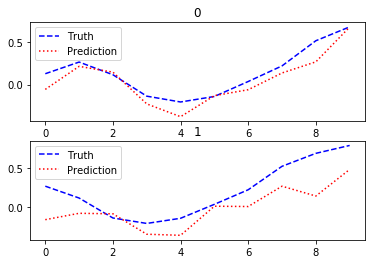

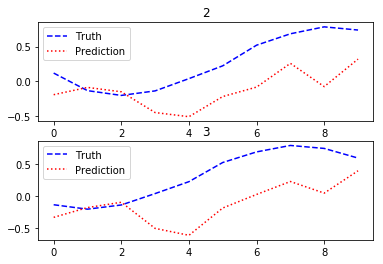

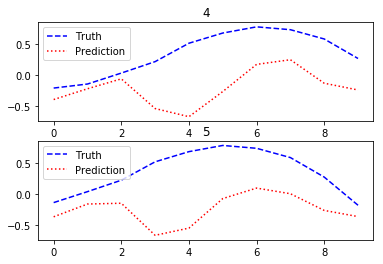

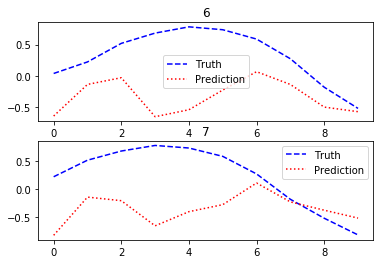

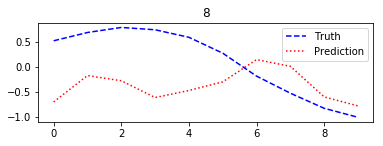

In [57]:
for t in range(9):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(val_labels[:, t][section], '--', label = "Truth", color = 'blue');
    plt.plot(individual_val_pred[t][section], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

CUMULATIVE

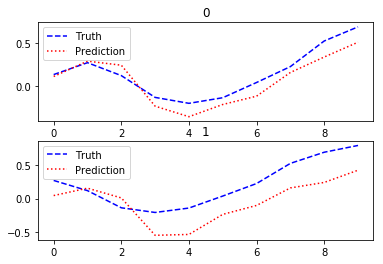

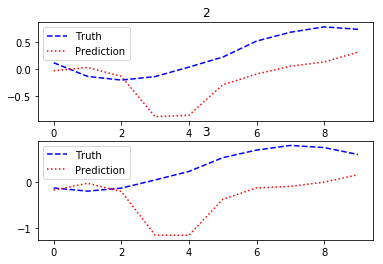

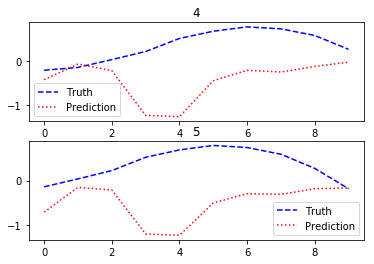

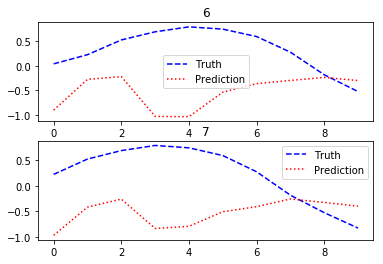

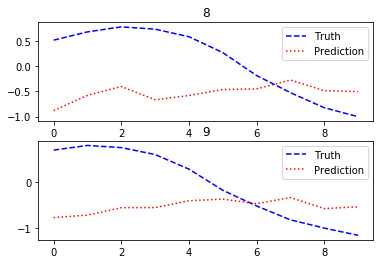

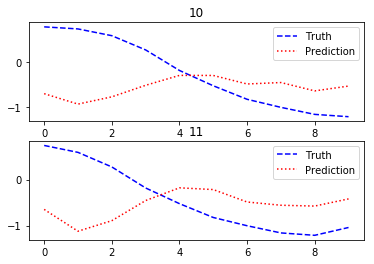

<Figure size 432x288 with 0 Axes>

In [58]:
for t in range(T):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(val_labels[:, t][section], '--', label = "Truth", color = 'blue');
    plt.plot(cumulative_val_pred[:, t][section], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

In [59]:
start = 0 * 12
end = start + 5 * 12

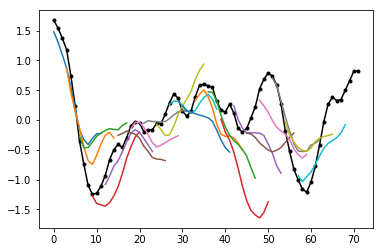

In [60]:
plt.plot(val_time2D[start:end + 12, 0].T - val_time2D[start, 0], val_labels[start:end + 12, 0], "k.-", label = "signal");
for t in range(start, end, 3):
    plt.plot(val_time2D[t] - val_time2D[start, 0], cumulative_val_pred[t], label = "%i" %(t % 12));

#plt.plot(val_time2D[start:end].T - val_time2D[start, 0], cumulative_val_pred[start:end].T);

# Comparing To Persistance

In [61]:
persistance_corr = np.zeros(T)
persistance_mse = np.zeros(T)

for t in range(T):
    persistance_corr[t] = correlation(output_signal[:(- t - 1)], output_signal[(t + 1):])
    persistance_mse[t] = mean_squared_error(output_signal[:(- t - 1)], output_signal[(t + 1):])

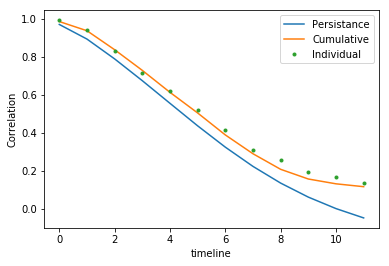

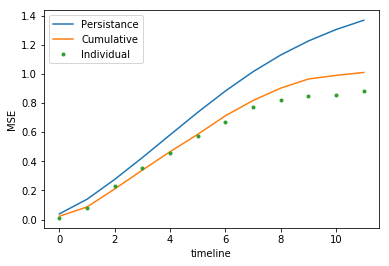

In [68]:
plt.plot(persistance_corr, label = "Persistance");
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, '.', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();


plt.plot(persistance_mse, label = "Persistance");
plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, '.', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

# Performance on Real World Data

In [74]:
datapath = 'om_nino34_monthly.nc'
om_nino34 = xarray.open_dataset(datapath, decode_times = False)
om_nino34 = np.array(om_nino34['nino34'].values)

/Users/paulag/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacello' has multiple fill values {-1e+34, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [75]:
om_clm = climatology(om_nino34)
om_anm = SST_anomaly(om_nino34, om_clm)
om_oni = ONI(om_anm)
om_time = np.arange(om_anm.shape[0])

In [76]:
om_input_signal = np.array(om_anm)
om_output_signal = np.array(om_oni)

om_input_signal = (om_input_signal - np.mean(om_input_signal)) / np.std(om_input_signal)

In [85]:
T = 12
H = 3  
Hmax = 48
features = H + 7 + 6 + 1 # 3 months of values / 7 x 3-month averages / 6 x 4-month months / current month

In [100]:
np.random.seed(0)
om_size = om_input_signal.shape[0] - Hmax - T 
        
om_data = np.ndarray((om_size, features))
for i in range(om_size):
    om_data[i, 0:H] = om_input_signal[(i + Hmax - H):(i + Hmax)] # past H exact values
    
    for j in range(7): # 7 x 3-month average
        om_data[i, H + j] = np.mean(om_input_signal[(i + Hmax - H - 3 * (j + 1)):(i + Hmax - H - 3 * j)])
    
    for j in range(6): # 6 x 4-month months
        om_data[i, H + 7 + j] = np.mean(om_input_signal[(i + Hmax - H - 3 * 7 - 4 * (j + 1)):(i + Hmax - H - 3 * 7 - 4 * j)])
        
    om_data[i, H + 7 + 6] = ((i + Hmax) % 12 - np.mean(range(12))) / np.std(range(12)) # current month
    

om_labels = np.ndarray((om_size, T), dtype = np.float64)
time2D = np.zeros((om_size, T))

for t in range(T):
    for i in range(om_size):
        om_labels[i,t] = om_output_signal[i + Hmax + t]
        om_time2D[i, t] = om_time[i + Hmax + t]

In [101]:
om_pred = cumulative_model.predict(om_data)

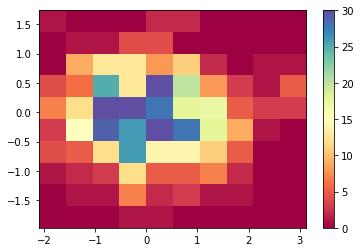

In [104]:
plt.hist2d(om_labels[:,-1], om_pred[:,-1], cmap = plt.cm.Spectral, vmax = 30);
plt.colorbar();

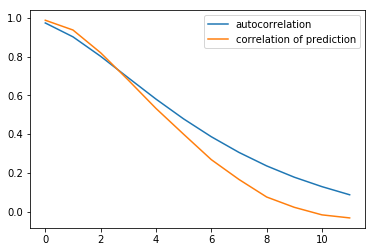

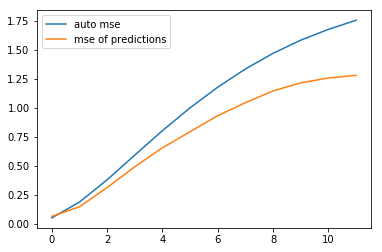

In [105]:
om_auto = np.zeros(T)
om_mse = np.zeros(T)

for t in range(T):
    om_auto[t] = correlation(om_output_signal[:(- t - 1)], om_output_signal[(t + 1):])
    om_mse[t] = mean_squared_error(om_output_signal[:(- t - 1)], om_output_signal[(t + 1):])
    
om_pred_mse = ((om_labels - om_pred)**2).mean(axis = 0)

plt.plot(om_auto, label = "autocorrelation");
plt.plot(correlation(om_labels, om_pred), label = "correlation of prediction");
plt.legend();
plt.figure();

plt.plot(om_mse, label = "auto mse");
plt.plot(om_pred_mse, label = "mse of predictions")
plt.legend();

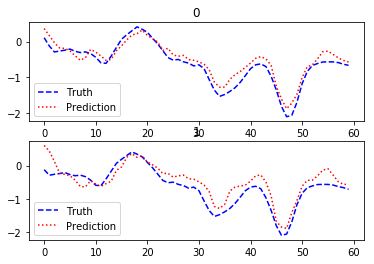

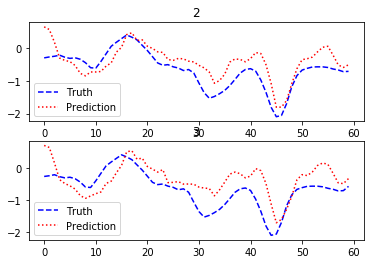

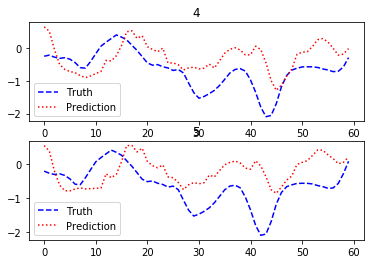

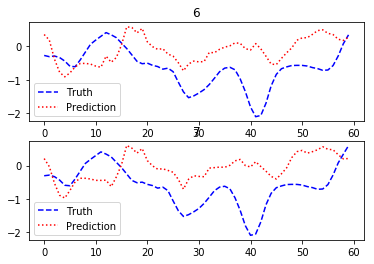

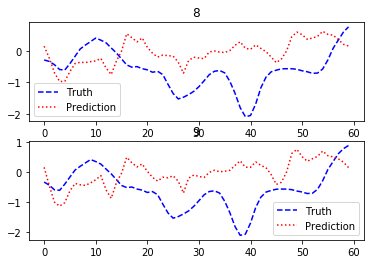

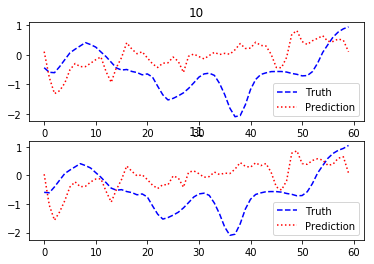

<Figure size 432x288 with 0 Axes>

In [106]:
for t in range(T):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(om_labels[:, t][start:end], '--', label = "Truth", color = 'blue');
    plt.plot(om_pred[:, t][start:end], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

In [107]:
start = 3 * 12
end = start + 3 * 12

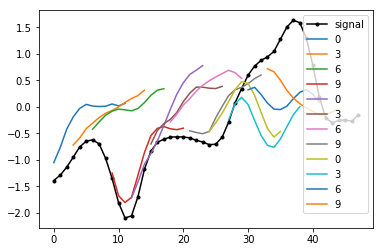

In [108]:
plt.plot(om_time2D[start:end + 12, 0].T - om_time2D[start, 0], om_labels[start:end + 12, 0], "k.-", label = "signal");
for t in range(start, end, 3):
    plt.plot(om_time2D[t] - om_time2D[start, 0], om_pred[t], label = "%i" %(t % 12));

plt.legend();